# <center>Comparison of performance of KNN algorithm and linear regression - case of violent crimes committed in different communities within the United States.</center>
<center>Final project for Machine Learning course</center>
<center><b>Ewelina Osowska, Ewa Sobolewska</b></center>

### Table of contents:
* [Dataset description](#dataset-description)
* [Data Preprocessing](#data-preprocessing)
* [Feature selection](#feature-selection)
* [Modelling](#modelling)
    * [Linear regression](#linear-regression)
    * [KNN regression](#knn-regression)
* [Validation and assessment](#validation-and-assessment)
* [Conclusions](#conclusions)

In [40]:
%autosave 0

Autosave disabled


In [ ]:
# Loading libraries
import pandas as pd
import warnings
from scipy import stats
from sklearn import feature_selection

# General settings
pd.set_option("display.max_columns",130)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Dataset description <a class="anchor" id="dataset-description"></a>

The dataset used in ...

Many variables are included so that algorithms that select or learn weights for attributes could be tested. However, clearly unrelated attributes were not included; attributes were picked if there was any plausible connection to crime (N=122), plus the attribute to be predicted (Per Capita Violent Crimes). The variables included in the dataset involve the community, such as the percent of the population considered urban, and the median family income, and involving law enforcement, such as per capita number of police officers, and percent of officers assigned to drug units. 

The per capita violent crimes variable was calculated using population and the sum of crime variables considered violent crimes in the United States: murder, rape, robbery, and assault. There was apparently some controversy in some states concerning the counting of rapes. These resulted in missing values for rape, which resulted in incorrect values for per capita violent crime. These cities are not included in the dataset. Many of these omitted communities were from the midwestern USA. 

Data is described below based on original values. All numeric data was normalized into the decimal range 0.00-1.00 using an Unsupervised, equal-interval binning method. Attributes retain their distribution and skew (hence for example the population attribute has a mean value of 0.06 because most communities are small). E.g. An attribute described as 'mean people per household' is actually the normalized (0-1) version of that value. 

The normalization preserves rough ratios of values WITHIN an attribute (e.g. double the value for double the population within the available precision - except for extreme values (all values more than 3 SD above the mean are normalized to 1.00; all values more than 3 SD below the mean are nromalized to 0.00)). 

However, the normalization does not preserve relationships between values BETWEEN attributes (e.g. it would not be meaningful to compare the value for whitePerCap with the value for blackPerCap for a community) 

A limitation was that the LEMAS survey was of the police departments with at least 100 officers, plus a random sample of smaller departments. For our purposes, communities not found in both census and crime datasets were omitted. Many communities are missing LEMAS data. 




The Law Enforcement Management and Administrative Statistics (LEMAS) survey collects data from a nationally representative sample of state, county, and local law enforcement agencies in the United States. For most questions, a reference date of June 30, 2016 was used.

The 2016 LEMAS sample design called for the survey questionnaire to be sent to 3,499 general purpose state and local law enforcement agencies. The design called for all agencies employing 100 or sworn personnel to be included with certainty (self-representing), and for smaller agencies to be sampled from strata based on number of sworn officers and type of agency.

A total of 27 local police departments were determined to be out-of-scope for the survey because they were special jurisdiction agencies, had closed, had outsourced their operations, or were operating on a part-time basis. The final mail out total of 3,472 agencies included 2,613 local police departments, 810 sheriffs' offices, and the 49 state agencies.

A total of 2,780 agencies responded to the LEMAS questionnaire, for a response rate of 80%. The final database includes responses from 2,136 local police departments, 600 sheriffs' offices, and 49 state law enforcement agencies (including partial responses from 5 primary state police agencies). The overall response rate for local police departments was 82%, 74% for sheriffs' offices, and 90% for state law enforcement agencies.

## Data preprocessing <a class="anchor" id="data-preprocessing"></a>

Before each step data is saved in reproducible form of a pickle. The data has 1994 observations and 128 columns. Each observation states for different communities. The steps necessary to get the pickle used below are attached in the supplement.

In [51]:
mydata = pd.read_pickle("mydata.p")

In [53]:
mydata.shape

(1994, 128)

In [54]:
mydata.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,0.49,0.44,0.75,0.65,0.54,0.83,0.65,0.85,0.86,0.03,0.33,0.02,0.11,0.20,0.30,0.31,0.05,0.08,0.11,0.11,0.81,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.1

In the dataset there are multiple missing values. They can be divided into three categories. Columns _county_ and _community_ don't have id numbers assigned, however these are only informational values and it doesn't affect the modelling process. Thus these columns may be ommitted without further consequences. The second category are columns that have 1675 missing values. They come from the 1990 LEMAS survey (The Law Enforcement Management and Administrative Statistics) and were not provided originally. Thus the filling of the variables is about 16%, we decided to discard these features from the analysis. The last category is one missing value in _OtherPerCap_ column. There are too few missing values in the column and also there no other important missing values in the row, so we cannot omit it. Taken steps will be explained later on.

In [35]:
print(mydata.isnull().sum()[mydata.isnull().sum()>1])

county                  1174
community               1177
OtherPerCap                1
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64


In [37]:
mydata = mydata.drop(["county", "community"], axis=1)

In [57]:
mydata = mydata.drop(mydata.columns[mydata.apply(lambda col: col.isnull().sum() > 1)], axis=1)

There are many missings inputation methods. As a first step, we checked the distribution of the variable. It seems that its values are aggregated between 0.17 (Q1) and 0.36 (Q3) overall and between 0.15 (Q1) and 0.315 (Q3) only in Mississippi - the state within which the missing value occurs. Thus we decided to fill the value with the median in this state.

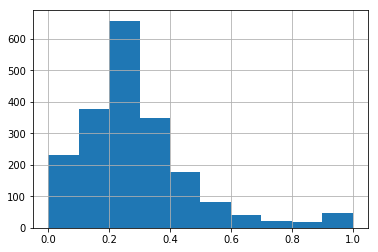

In [81]:
mydata.OtherPerCap.hist() # może w jednym plocie? :))):):):

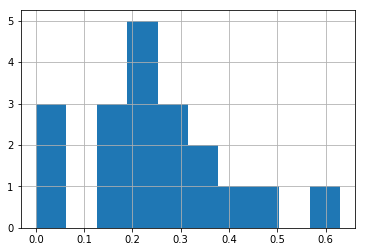

In [82]:
mydata[mydata.state==28].OtherPerCap.hist()

In [75]:
mydata[mydata.OtherPerCap.isna()]

,state,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop


In [77]:
mydata.OtherPerCap.quantile([0.25, 0.5, 0.75])

0.25    0.17
0.50    0.25
0.75    0.36
Name: OtherPerCap, dtype: float64

In [78]:
mydata[mydata.state==28].OtherPerCap.quantile([0.25, 0.5, 0.75])

0.25    0.150
0.50    0.230
0.75    0.315
Name: OtherPerCap, dtype: float64

In [74]:
mydata.loc[130, "OtherPerCap"] = 0.23

In [83]:
mydata.to_pickle("mydata_step1.p")

## Feature selection <a class="anchor" id="feature-selection"></a>

In [38]:
numCols = ["population",
"householdsize",
"racepctblack",
"racePctWhite",
"racePctAsian",
"racePctHisp",
"agePct12t21",
"agePct12t29",
"agePct16t24",
"agePct65up",
"numbUrban",
"pctUrban",
"medIncome",
"pctWWage",
"pctWFarmSelf",
"pctWInvInc",
"pctWSocSec",
"pctWPubAsst",
"pctWRetire",
"medFamInc",
"perCapInc",
"whitePerCap",
"blackPerCap",
"indianPerCap",
"AsianPerCap",
"OtherPerCap",
"HispPerCap",
"NumUnderPov",
"PctPopUnderPov",
"PctLess9thGrade",
"PctNotHSGrad",
"PctBSorMore",
"PctUnemployed",
"PctEmploy",
"PctEmplManu",
"PctEmplProfServ",
"PctOccupManu",
"PctOccupMgmtProf",
"MalePctDivorce",
"MalePctNevMarr",
"FemalePctDiv",
"TotalPctDiv",
"PersPerFam",
"PctFam2Par",
"PctKids2Par",
"PctYoungKids2Par",
"PctTeen2Par",
"PctWorkMomYoungKids",
"PctWorkMom",
"NumIlleg",
"PctIlleg",
"NumImmig",
"PctImmigRecent",
"PctImmigRec5",
"PctImmigRec8",
"PctImmigRec10",
"PctRecentImmig",
"PctRecImmig5",
"PctRecImmig8",
"PctRecImmig10",
"PctSpeakEnglOnly",
"PctNotSpeakEnglWell",
"PctLargHouseFam",
"PctLargHouseOccup",
"PersPerOccupHous",
"PersPerOwnOccHous",
"PersPerRentOccHous",
"PctPersOwnOccup",
"PctPersDenseHous",
"PctHousLess3BR",
"MedNumBR",
"HousVacant",
"PctHousOccup",
"PctHousOwnOcc",
"PctVacantBoarded",
"PctVacMore6Mos",
"MedYrHousBuilt",
"PctHousNoPhone",
"PctWOFullPlumb",
"OwnOccLowQuart",
"OwnOccMedVal",
"OwnOccHiQuart",
"RentLowQ",
"RentMedian",
"RentHighQ",
"MedRent",
"MedRentPctHousInc",
"MedOwnCostPctInc",
"MedOwnCostPctIncNoMtg",
"NumInShelters",
"NumStreet",
"PctForeignBorn",
"PctBornSameState",
"PctSameHouse85",
"PctSameCity85",
"PctSameState85",
"LemasSwornFT",
"LemasSwFTPerPop",
"LemasSwFTFieldOps",
"LemasSwFTFieldPerPop",
"LemasTotalReq",
"LemasTotReqPerPop",
"PolicReqPerOffic",
"PolicPerPop",
"RacialMatchCommPol",
"PctPolicWhite",
"PctPolicBlack",
"PctPolicHisp",
"PctPolicAsian",
"PctPolicMinor",
"OfficAssgnDrugUnits",
"NumKindsDrugsSeiz",
"PolicAveOTWorked",
"LandArea",
"PopDens",
"PctUsePubTrans",
"PolicCars",
"PolicOperBudg",
"LemasPctPolicOnPatr",
"LemasGangUnitDeploy",
"LemasPctOfficDrugUn",
"PolicBudgPerPop"]

In [39]:
minfos=[]
for var in numCols:
    print(var, " Mutual info", feature_selection.mutual_info_regression(mydata[var].astype(float).values.reshape(-1,1),mydata["ViolentCrimesPerPop"].astype(float).values))
    minfos.append(feature_selection.mutual_info_regression(mydata[var].astype(float).values.reshape(-1,1),mydata["ViolentCrimesPerPop"].astype(float).values))
imp = list(zip(minfos, numCols))
imp.sort(reverse=True)
imp

population  Mutual info [0.10059045]
householdsize  Mutual info [0.04602091]
racepctblack  Mutual info [0.25216102]
racePctWhite  Mutual info [0.33704647]
racePctAsian  Mutual info [0]
racePctHisp  Mutual info [0.12924523]
agePct12t21  Mutual info [0.03064168]
agePct12t29  Mutual info [0.09095695]
agePct16t24  Mutual info [0.1129868]
agePct65up  Mutual info [0.0375671]
numbUrban  Mutual info [0.12073321]
pctUrban  Mutual info [0.06669631]
medIncome  Mutual info [0.15143512]
pctWWage  Mutual info [0.04223415]
pctWFarmSelf  Mutual info [0.02289105]
pctWInvInc  Mutual info [0.29164984]
pctWSocSec  Mutual info [0.03033903]
pctWPubAsst  Mutual info [0.27200413]
pctWRetire  Mutual info [0.02157662]
medFamInc  Mutual info [0.19600032]
perCapInc  Mutual info [0.11520848]
whitePerCap  Mutual info [0.065202]
blackPerCap  Mutual info [0.1461872]
indianPerCap  Mutual info [0.08633016]
AsianPerCap  Mutual info [0.06072306]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Modelling <a class="anchor" id="modelling"></a>

### Linear regression <a class="anchor" id="linear-regression"></a>

### KNN regression <a class="anchor" id="knn-regression"></a>

## Validation and assessment <a class="anchor" id="validation-and-assessment"></a>

## Conclusions <a class="anchor" id="conclusions"></a>